## Climate time series analysis
* Charge and preprocess data
* Time series clustering 
* Causal analysis


On this first notebook we preprocess data and train our clustering model for a small set of 180 pixels. 

In [1]:
import pandas as pd
import numpy as np
import os
import datetime
from tensorflow.keras import layers, Model
import tensorflow as tf
from tslearn.clustering import TimeSeriesKMeans
from tslearn.barycenters import dtw_barycenter_averaging as dtw_avg
import geopandas as gpd
import matplotlib.pyplot as plt
%matplotlib inline     

In [2]:
col_names = pd.read_csv('../dades/col_names.txt', header=None)
df = pd.DataFrame()

df.loc[:,'timestamp'] = pd.read_csv('../dades/data_per_pix/-0.5,-48.5.csv', header=None).loc[:,0].apply(datetime.datetime.fromtimestamp)

In [52]:
variables_names = ['Lag_RN_ERA_Ix5day_2', 'Lag_SM_GLEAM_ResPlusTrend_Sx5day_2','maxTXx_cum_T_ERA_2', 'monthly_Rx1day_P_CPCU']
variables_ind = [1486, 2109, 4225, 5007]

* Temperatura en Kelvin


In [2]:
df = np.empty((len(os.listdir('../test_data/assaig1/')),385,4))
pixels = []
i = 0



for file in os.listdir('../test_data/assaig1/'):
    df[i,:,:] = pd.read_csv(os.path.join('../test_data/assaig1/', file), header=None)
    i += 1
    pixels.append(file)
    
df = df[:,1:,:]

In [4]:
inp = layers.Input(shape=(df.shape[1], df.shape[2]))
    

encoder = layers.TimeDistributed(layers.Dense(50, activation='tanh'))(inp)
encoder = layers.TimeDistributed(layers.Dense(10, activation='tanh'))(encoder)
latent = layers.TimeDistributed(layers.Dense(1, activation='tanh'))(encoder)
decoder = layers.TimeDistributed(layers.Dense(10, activation='tanh'))(latent)
decoder = layers.TimeDistributed(layers.Dense(50, activation='tanh'))(decoder)
out = layers.TimeDistributed(layers.Dense(4))(decoder)

autoencoder = Model(inputs=inp, outputs=out)
autoencoder.compile(optimizer='adam', loss='mse')


autoencoder.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 384, 4)]          0         
                                                                 
 time_distributed (TimeDistr  (None, 384, 50)          250       
 ibuted)                                                         
                                                                 
 time_distributed_1 (TimeDis  (None, 384, 10)          510       
 tributed)                                                       
                                                                 
 time_distributed_2 (TimeDis  (None, 384, 1)           11        
 tributed)                                                       
                                                                 
 time_distributed_3 (TimeDis  (None, 384, 10)          20        
 tributed)                                                   

In [5]:
ind = np.random.permutation(df.shape[0])
training_idx, test_idx = ind[:120], ind[120:]
x_train, x_test = df[training_idx,:,:], df[test_idx,:,:]

In [8]:
history = autoencoder.fit(x_train, x_train, epochs = 25000, validation_data= (x_test, x_test))

Epoch 1/5000
4/4 [==============================] - 0s 38ms/step - loss: 33.4387 - val_loss: 34.8735
Epoch 2/5000
4/4 [==============================] - 0s 22ms/step - loss: 33.0699 - val_loss: 35.8730
Epoch 3/5000
4/4 [==============================] - 0s 21ms/step - loss: 32.9326 - val_loss: 34.8287
Epoch 4/5000
4/4 [==============================] - 0s 21ms/step - loss: 33.0705 - val_loss: 35.3988
Epoch 5/5000
4/4 [==============================] - 0s 22ms/step - loss: 33.0973 - val_loss: 35.3876
Epoch 6/5000
4/4 [==============================] - 0s 22ms/step - loss: 33.0096 - val_loss: 34.8325
Epoch 7/5000
4/4 [==============================] - 0s 22ms/step - loss: 33.2893 - val_loss: 34.8873
Epoch 8/5000
4/4 [==============================] - 0s 22ms/step - loss: 32.5900 - val_loss: 34.8141
Epoch 9/5000
4/4 [==============================] - 0s 22ms/step - loss: 32.5032 - val_loss: 34.6611
Epoch 10/5000
4/4 [==============================] - 0s 22ms/step - loss: 32.3342 - val_los

In [9]:
encoder = Model(inputs=inp, outputs=latent)
encoder.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 384, 4)]          0         
                                                                 
 time_distributed (TimeDistr  (None, 384, 50)          250       
 ibuted)                                                         
                                                                 
 time_distributed_1 (TimeDis  (None, 384, 10)          510       
 tributed)                                                       
                                                                 
 time_distributed_2 (TimeDis  (None, 384, 1)           11        
 tributed)                                                       
                                                                 
Total params: 771
Trainable params: 771
Non-trainable params: 0
_____________________________________________________________

In [10]:
autoencoder.save('./my_model')
encoder.save('./my_encoder')

INFO:tensorflow:Assets written to: ./my_model\assets


INFO:tensorflow:Assets written to: ./my_model\assets


INFO:tensorflow:Assets written to: ./my_encoder\assets


INFO:tensorflow:Assets written to: ./my_encoder\assets


In [11]:
data = encoder.predict(df)

6/6 [==============================] - 0s 2ms/step


In [12]:
data = data.reshape((len(os.listdir('../test_data/assaig1/')), 384))

In [13]:
data = pd.DataFrame(data, index = pixels)

In [14]:
model = TimeSeriesKMeans(n_clusters=7, metric="dtw", max_iter=30000)
model.fit(data)

TimeSeriesKMeans(max_iter=30000, metric='dtw', n_clusters=7)

In [15]:
results = pd.DataFrame()

In [16]:
results['group'] = model.predict(data)


c:\Users\Usuario\anaconda3\lib\site-packages\tslearn\utils\utils.py:88: UserWarning: 2-Dimensional data passed. Assuming these are 184 1-dimensional timeseries
  warnings.warn('2-Dimensional data passed. Assuming these are '


In [17]:
coord_x = []
coord_y = []

for i in range(len(pixels)):
    pixels[i] = pixels[i].replace('.csv', '')
    coord_x.append(float(pixels[i].split(',')[1]))
    coord_y.append(float(pixels[i].split(',')[0]))

In [18]:
results['coord_x'] = coord_x
results['coord_y'] = coord_y


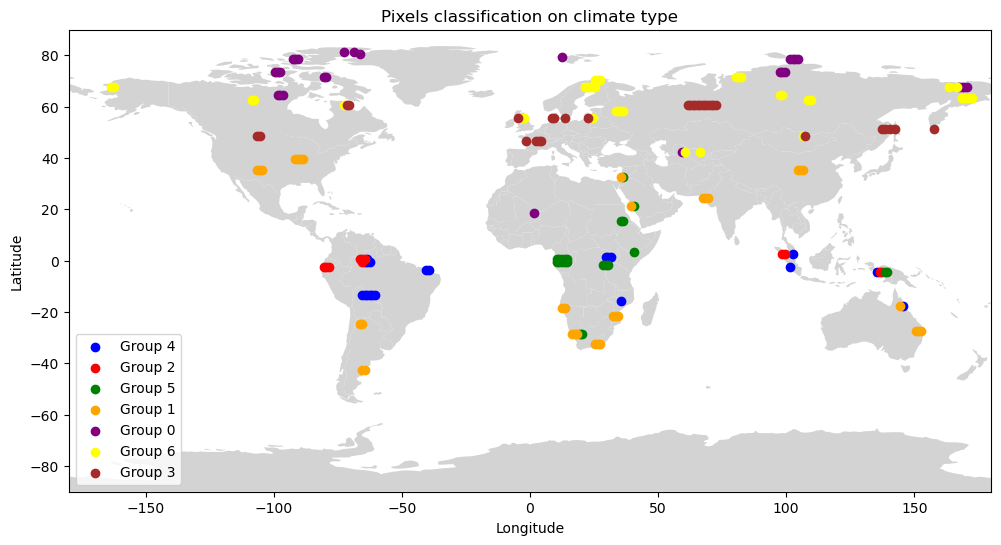

In [20]:
# From GeoPandas, our world map data
worldmap = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

# Creating axes and plotting world map
fig, ax = plt.subplots(figsize=(12, 6))
worldmap.plot(color="lightgrey", ax=ax)

for group, color in zip(results['group'].unique(), ['blue', 'red', 'green', 'orange', 'purple', 'yellow', 'brown']):
    plt.scatter(x = results.coord_x[results['group'] == group], y = results.coord_y[results['group'] == group], color=color, label=f"Group {group}")

# Creating axis limits and title
plt.xlim([-180, 180])
plt.ylim([-90, 90])

plt.title('Pixels classification on climate type')
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.legend()
plt.show()

In [21]:
mean_series = np.empty((len(set(results['group'])),384,4))

for i in set(results['group']):
    for j in range(4):
        mean_series[i,:,j] = dtw_avg(df[results['group'] == i,:,j], max_iter = 10000).reshape([384,])

Text(0.5, 1.0, 'Precipitation')

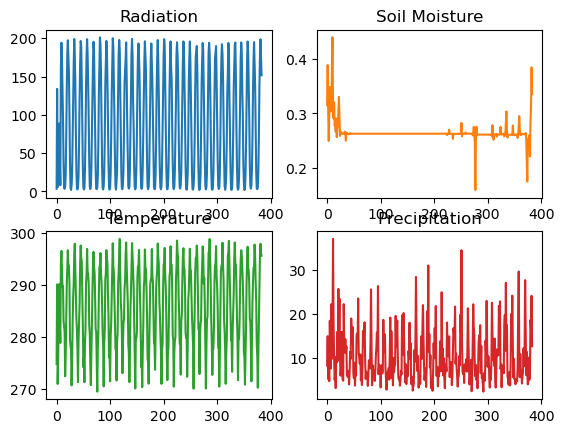

In [22]:
# Mitjana de cada variable per al cluster 3
fig, axs = plt.subplots(2, 2)
axs[0, 0].plot(mean_series[3,:,0])
axs[0, 0].set_title('Radiation')
axs[0, 1].plot(mean_series[3,:,1], 'tab:orange')
axs[0, 1].set_title('Soil Moisture')
axs[1, 0].plot(mean_series[3,:,2], 'tab:green')
axs[1, 0].set_title('Temperature')
axs[1, 1].plot(mean_series[3,:,3], 'tab:red')
axs[1, 1].set_title('Precipitation')

In [33]:
for i in range(mean_series.shape[0]):
    np.savetxt(f"{'./mean_series/'}{i}{'.txt'}", mean_series[i,:,:])